In [10]:
import xarray as xr
import numpy as np
from scipy.signal import detrend
from scipy.fft import fft
from scipy.stats import chi2

def power_spectral_analysis_xarray(data_array, dim, fs):
    # 預處理：去除線性趨勢
    data_detrended = xr.apply_ufunc(detrend, data_array, kwargs={'axis': -1})
    
    # 使用FFT計算頻譜
    n = len(data_array[dim])
    freq = np.fft.fftfreq(n, d=1/fs)
    psd = xr.apply_ufunc(fft, data_detrended, kwargs={'n': n, 'axis': -1})
    psd = xr.DataArray(np.abs(psd)**2 / (fs*n), dims=['freq'], coords={'freq': freq})
    
    return psd.sel({'freq': freq >= 0})  # 只返回正頻率部分

In [20]:
def calculate_markov_spectrum(data_array, dim, fs):
    # 預處理：去除線性趨勢
    data_detrended = xr.apply_ufunc(detrend, data_array, kwargs={'axis': -1})
    
    # 使用FFT計算頻譜
    n = len(data_array[dim])
    freq = np.fft.fftfreq(n, d=1/fs)
    psd = xr.apply_ufunc(fft, data_detrended, kwargs={'n': n, 'axis': -1})
    psd = xr.DataArray(np.abs(psd)**2 / (fs*n), dims=['freq'], coords={'freq': freq})
    
    # 只返回正頻率部分
    psd = psd.sel({'freq': freq >= 0})
    
    # 計算理論馬爾可夫譜
    markov_spectrum = psd.copy()
    markov_spectrum.values = markov_spectrum.values / (1 - (2 * np.pi * markov_spectrum['freq'])**2)
    
    return markov_spectrum

def calculate_confidence_intervals(psd, alpha=0.05):
    # 計算自由度
    dof = len(psd) * 2  # 假設使用5點平滑器
    # 計算置信區間
    chi2_lower = chi2.ppf(alpha / 2, dof)
    chi2_upper = chi2.ppf(1 - alpha / 2, dof)
    
    lower_bound = psd * dof / chi2_upper
    upper_bound = psd * dof / chi2_lower
    
    return lower_bound, upper_bound

In [21]:
# 示例使用
# 假設fs是採樣頻率，data是氣象數據
fs = 1.0  # 每天採樣一次
pcp = (xr.open_dataarray('./data/cmorph_sample.nc')
         .sel(time=slice('2017-12-01','2018-02-28'),lat=slice(9,14),lon=slice(122,127))
         .mean(axis=(1,2)))

# 計算功率譜
power_spectrum = power_spectral_analysis_xarray(pcp, 'time', fs)

theo_spectrum = calculate_markov_spectrum(pcp, 'time', fs)

# 計算紅噪音置信區間
lower_bound, upper_bound = calculate_confidence_intervals(theo_spectrum)


power_spectrum 

<xarray.DataArray 'cmorph' (freq: 45)>
array([6.4675180e-13, 6.3325989e+01, 2.2585947e+02, 8.8938690e+02,
       9.3156091e+02, 1.7199724e+03, 3.2662427e+03, 1.2981198e+02,
       8.4086105e+01, 2.5625293e+03, 1.8077504e+03, 4.0544168e+02,
       5.1551141e+02, 2.9986380e+02, 2.8481366e+02, 2.0516897e+03,
       1.2709663e+02, 9.4400269e+02, 1.3857310e+02, 4.0833969e+01,
       1.7673550e+02, 4.5244193e+02, 2.4652669e+02, 6.0125824e+02,
       2.3931200e+02, 3.3621228e+02, 6.6129715e+01, 4.2013196e+02,
       2.3398594e+01, 2.9224750e+02, 7.8697441e+01, 2.8436295e+02,
       6.5966687e+02, 1.6861514e+02, 1.3255989e+02, 1.3755678e+02,
       7.1082687e+01, 1.5459321e+01, 9.1032646e+01, 6.3618832e+01,
       5.5677280e+01, 2.6239355e+02, 1.6184459e+02, 9.7820770e+01,
       9.3672979e-01], dtype=float32)
Coordinates:
  * freq     (freq) float64 0.0 0.01111 0.02222 0.03333 ... 0.4667 0.4778 0.4889

In [22]:
period = 1. / power_spectrum.freq

In [23]:
lower_bound

<xarray.DataArray 'cmorph' (freq: 45)>
array([ 4.92717844e-13,  4.84802104e+01,  1.75488780e+02,  7.08650526e+02,
        7.69719570e+02,  1.49214806e+03,  3.01784666e+03,  1.29923612e+02,
        9.31003138e+01,  3.22566459e+03,  2.68664462e+03,  7.52885869e+02,
        1.31718693e+03,  1.29567673e+03,  4.85201216e+03, -1.61768180e+04,
       -3.90882252e+02, -1.76030389e+03, -1.82288176e+02, -4.09610887e+01,
       -1.41796636e+02, -2.99888391e+02, -1.38203414e+02, -2.90226540e+02,
       -1.00874607e+02, -1.25179038e+02, -2.19544937e+01, -1.25367727e+02,
       -6.31871405e+00, -7.18454711e+01, -1.77039978e+01, -5.88082024e+01,
       -1.25927249e+02, -2.98206024e+01, -2.17920282e+01, -2.10834867e+01,
       -1.01857928e+01, -2.07629380e+00, -1.14861179e+01, -7.55742091e+00,
       -6.23942170e+00, -2.77910107e+01, -1.62288168e+01, -9.30168283e+00,
       -8.45954872e-02])
Coordinates:
  * freq     (freq) float64 0.0 0.01111 0.02222 0.03333 ... 0.4667 0.4778 0.4889

In [24]:
power_spectrum = power_spectrum.assign_coords(period=period)

lower_bound = lower_bound.assign_coords(period=period)
upper_bound = upper_bound.assign_coords(period=period)

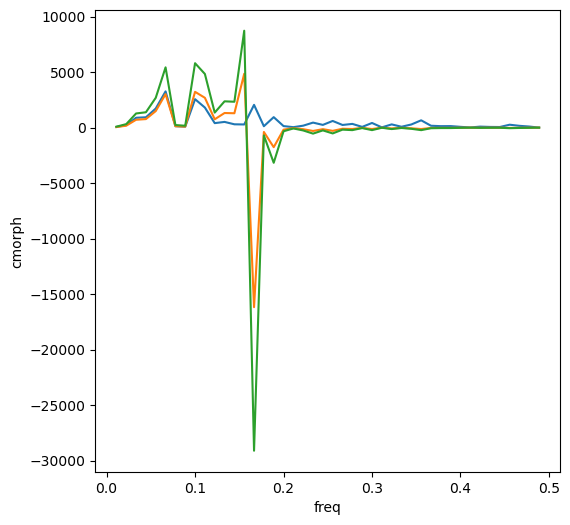

In [25]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,6))

ps_plt = power_spectrum[1:].plot.line(x='freq',ax=ax)
lb_plt = lower_bound[1:].plot.line(x='freq',ax=ax)
ub_plt = upper_bound[1:].plot.line(x='freq',ax=ax)